In [1]:
import numpy as np
import os
import sys
import copy
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from collections import OrderedDict
import time
import loadcifar
from loadcifar import *
list_pathstoadd = [
    "../../"
]
for path in list_pathstoadd:
    if(path not in sys.path):
        sys.path.append(path)
#import generalGPmodule
import localsrc_cifar10demo
from localsrc_cifar10demo import *
import gpex
import resnetforcifar
from resnetforcifar import *
from gpex.kernelmappings.image import Resnet50BackboneKernelDivideAvgPool
tfm_denormalize = loadcifar.ImgnetDenormalize()

In [2]:
#settings ====
idx_trainingbatch = 1
flag_enabledataaugmentation = True
fname_gpmodel = os.path.join(
    "..",
    "..",
    "Material_PaperResults",
    "Models",
    "ExplainClassifier",
    "cifar10.pt"
)

#"../../Material_PaperResults/Models/ExplainClassifier/cifar10.pt"
flag_loadalltraining = True
int_mode_modulekernel = 16
flag_train_memefficient, memefficeint_heads_in_compgraph = False, None
du_per_class = 20
int_exposedclass = None
idx_split = 0
dim_wideoutput = 1024
flag_loadalltraining = False
num_classes = 10
batchsize = 10
flag_efficient = True
flag_detachcovpvn = True
flag_controlvariate = True
flag_setcovtoOne = False
int_mode_controlvariate = 2

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
#make datasets ====
ds_rootdir = os.path.join(
    "..",
    "..",
    "Material_PaperResults",
    "Datasets",
    "Cifar10"
)

ds_train = Cifar10Dataset(
    rootdir = ds_rootdir,
    fname_batchfile = "data_batch_1",
    str_trainoreval = "train",
    flag_enabledataaugmentation = flag_enabledataaugmentation,
    flag_loadalltraining = flag_loadalltraining,
)
ds_inducing = Cifar10Dataset(
    rootdir = ds_rootdir,
    fname_batchfile = "data_batch_1",
    str_trainoreval = "eval",
    flag_loadalltraining = flag_loadalltraining,
)
ds_test = Cifar10Dataset(
    rootdir = ds_rootdir,
    fname_batchfile = "test_batch",
    str_trainoreval = "eval"
)

In [5]:
dl_train = DataLoader(ds_train, batch_size=batchsize,
                      shuffle=True, num_workers=0)
dl_inducing = DataLoader(ds_inducing, batch_size=batchsize,
                          shuffle=True, num_workers=0)
dl_test = DataLoader(ds_test, batch_size=batchsize,
                     shuffle=False, num_workers=0)

In [6]:
model = MainModule(
    dim_wideoutput=dim_wideoutput,
    num_classes = num_classes,
    device = device,
    ds_inducing = ds_inducing,
    dl_recurring = dl_inducing,
    dl_nonrecurring = dl_train,
    dl_test = dl_test,
    batchsize = batchsize
  )

model.to(device)
print("Model was created in {}.".format(device))

C_head is equal to 2048.
<><><><><><><><><> finisehd creating module_tail <><><><><><><><>.
Model was created in cuda:0.


In [7]:
#model.n_subsampleminibatch = 2
gpexmodule = gpex.GPEXModule(
    module_rawmodule = model,
    size_recurringdataset = len(ds_inducing),
    device = device,
    func_mainmodule_to_moduletobecomeGP = model.func_mainmodule_to_moduletobecomeGP, 
    func_feed_noise_minibatch = model.func_feed_noise_minibatch,
    func_feed_recurring_minibatch = model.func_feed_recurring_minibatch,
    func_feed_nonrecurring_minibatch = model.func_feed_nonrecurring_minibatch,
    func_feed_test_minibatch = model.func_feed_test_minibatch,
    func_get_indices_lastrecurringinstances = model.func_get_indices_lastrecurringinstances,
    func_get_modulef1 = model.func_get_modulef1
)
gpexmodule.sigma2_GP = 1.0 #TODO:check
gpexmodule.to(device)
print("gpmodel was created on {}".format(device))

Controlvariate mode is set to 2
x.shape = torch.Size([10, 3, 32, 32])
    Dv was set to 10
gpmodel was created on cuda:0


In [8]:
#load model from checkpoint ====
gpexmodule.load_state_dict(
    torch.load(
        fname_gpmodel
     ),
    strict = True
)
gpexmodule.train()
gpexmodule.to(device)
gpexmodule.renew_precomputed_XTX()
print("gpmodel was loaded from checkpoint.")

gpmodel was loaded from checkpoint.


a-b in range [-2.692254066467285 , 2.6703929901123047]


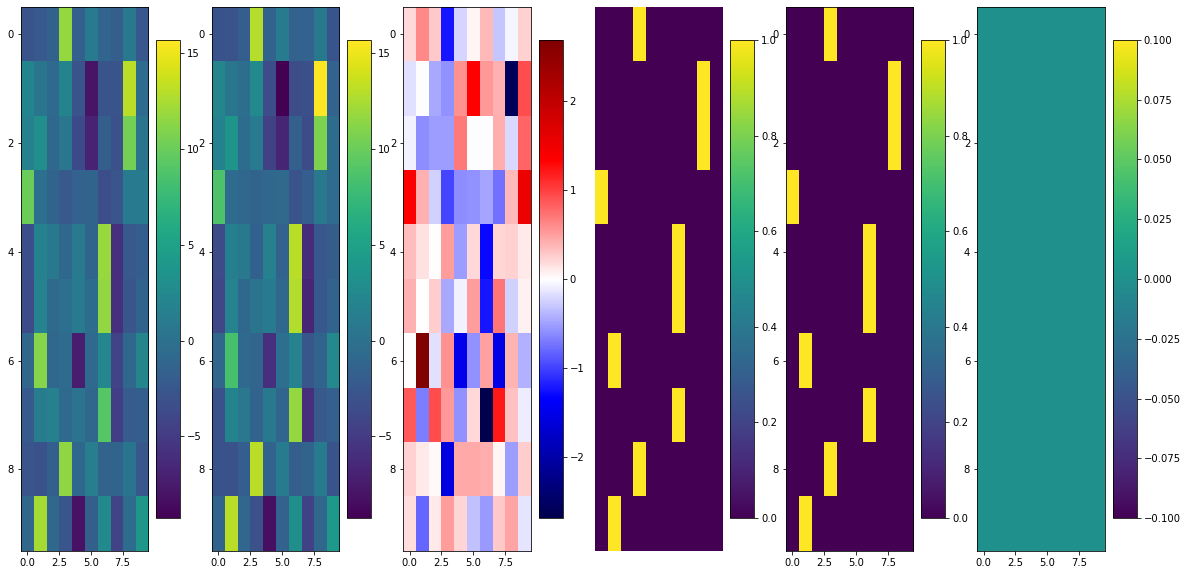

a-b in range [-2.817599296569824 , 3.3641562461853027]


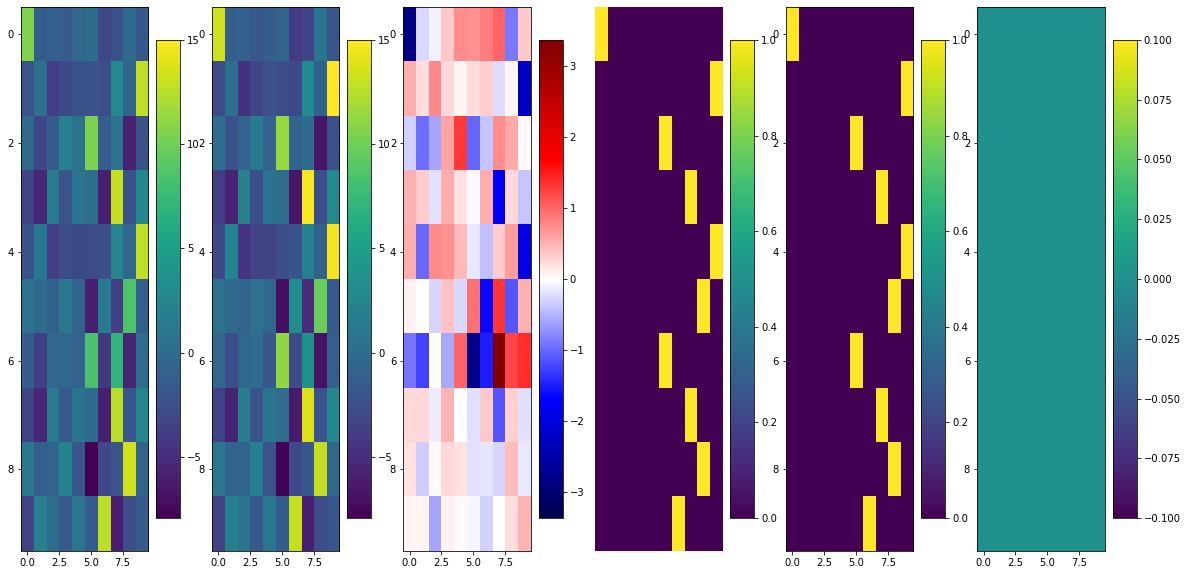

a-b in range [-5.323446750640869 , 5.586970806121826]


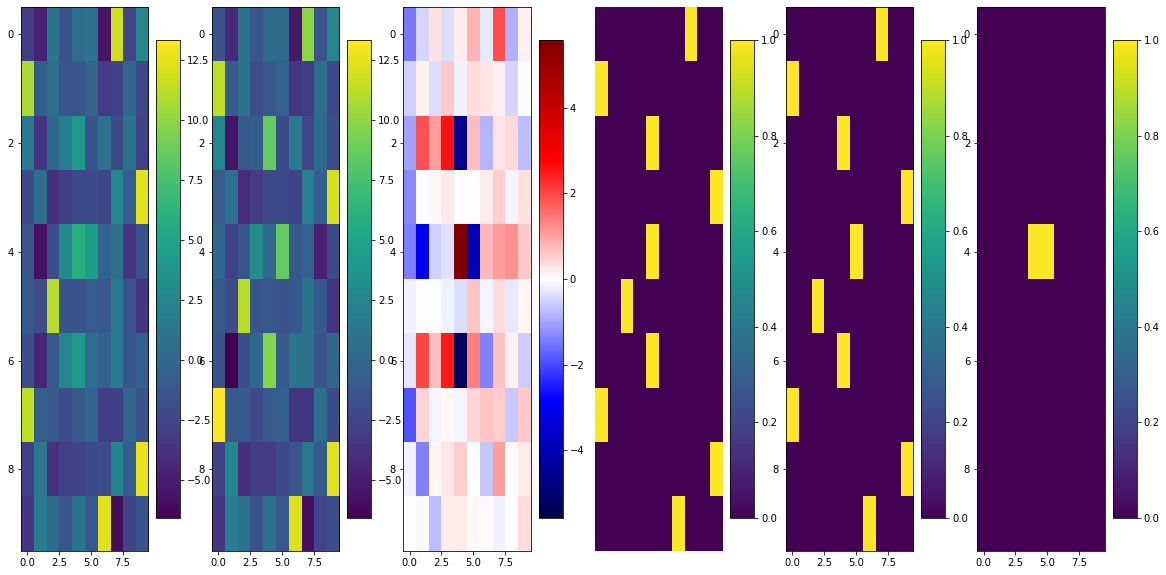

a-b in range [-7.610431671142578 , 6.442885875701904]


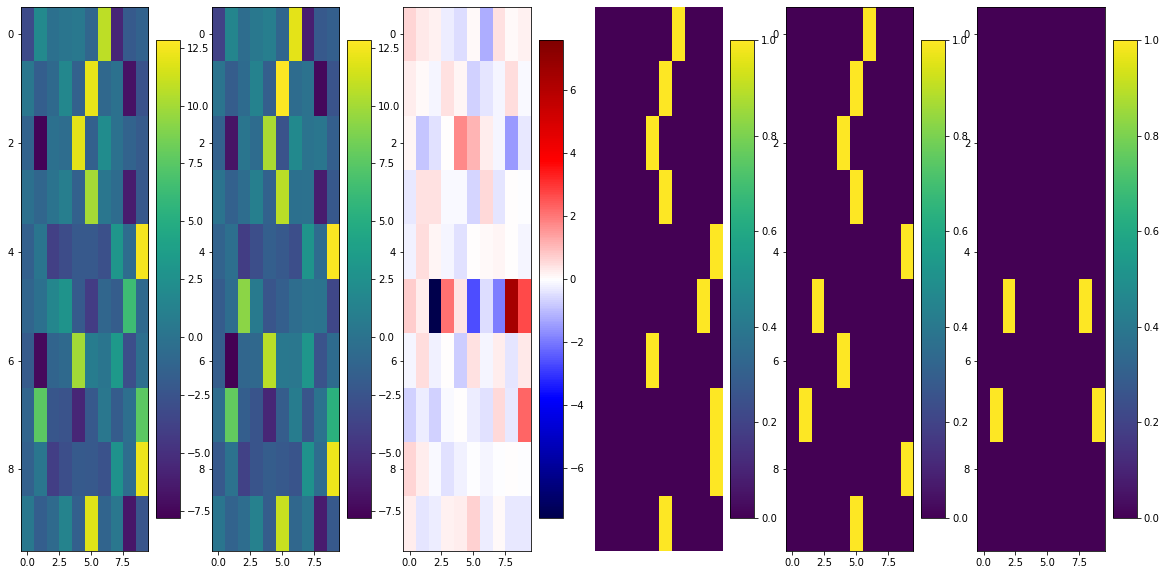

a-b in range [-6.8086395263671875 , 5.2136077880859375]


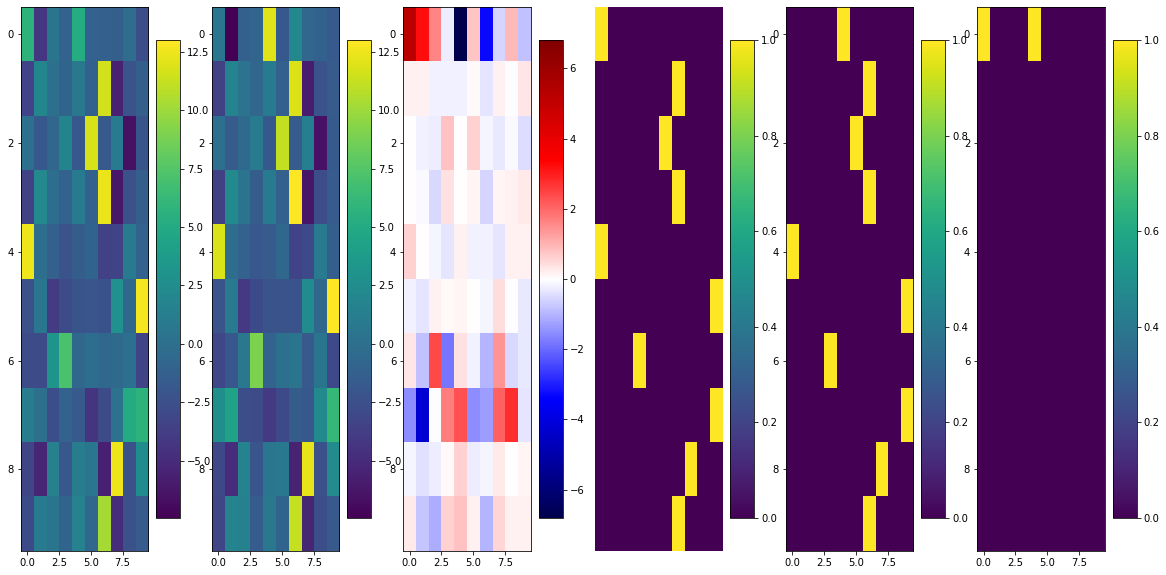

a-b in range [-4.5967864990234375 , 2.872354507446289]


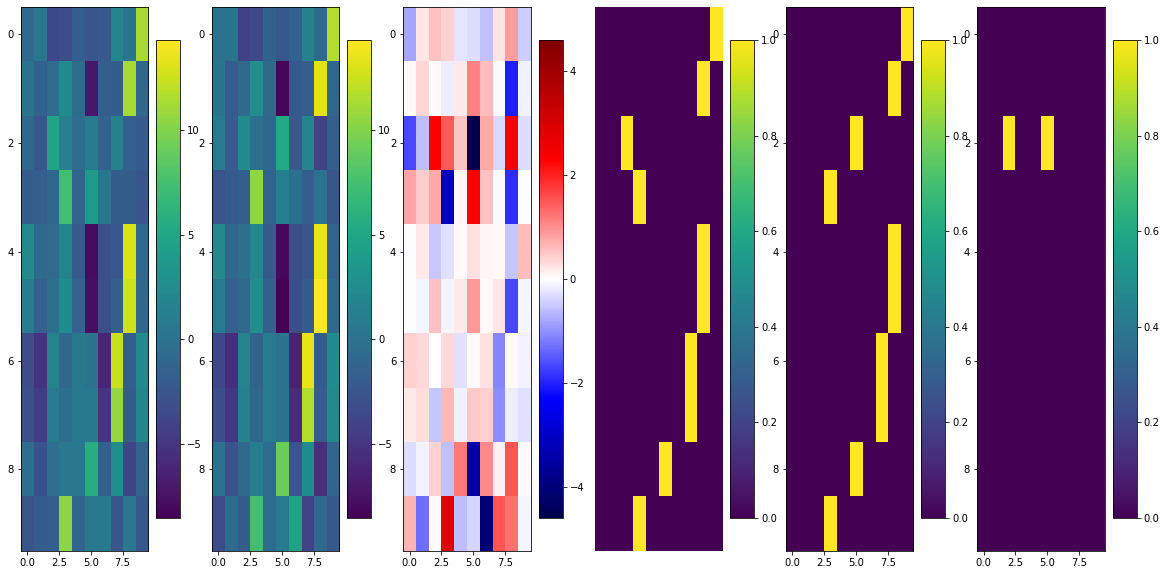

a-b in range [-3.1309375762939453 , 3.173007011413574]


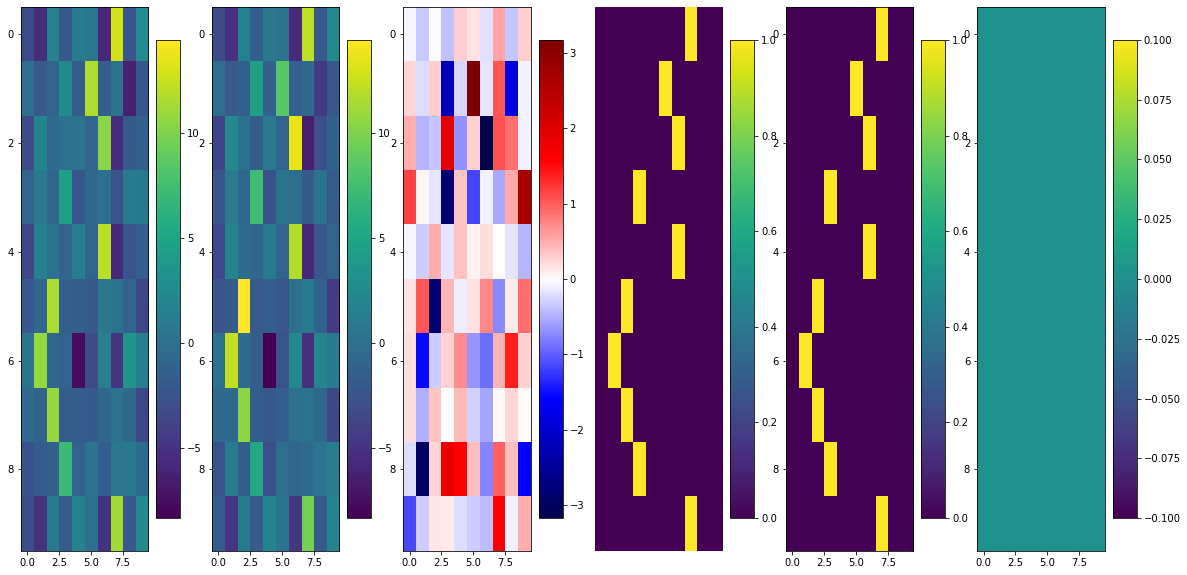

a-b in range [-2.795957565307617 , 1.6173114776611328]


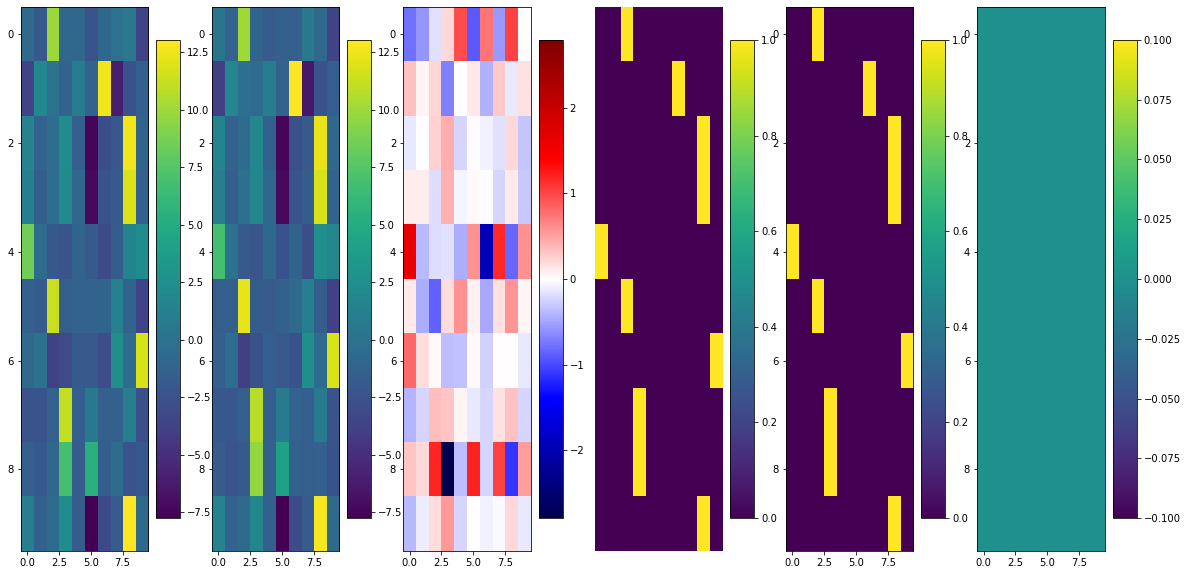

a-b in range [-7.164377212524414 , 6.092073440551758]


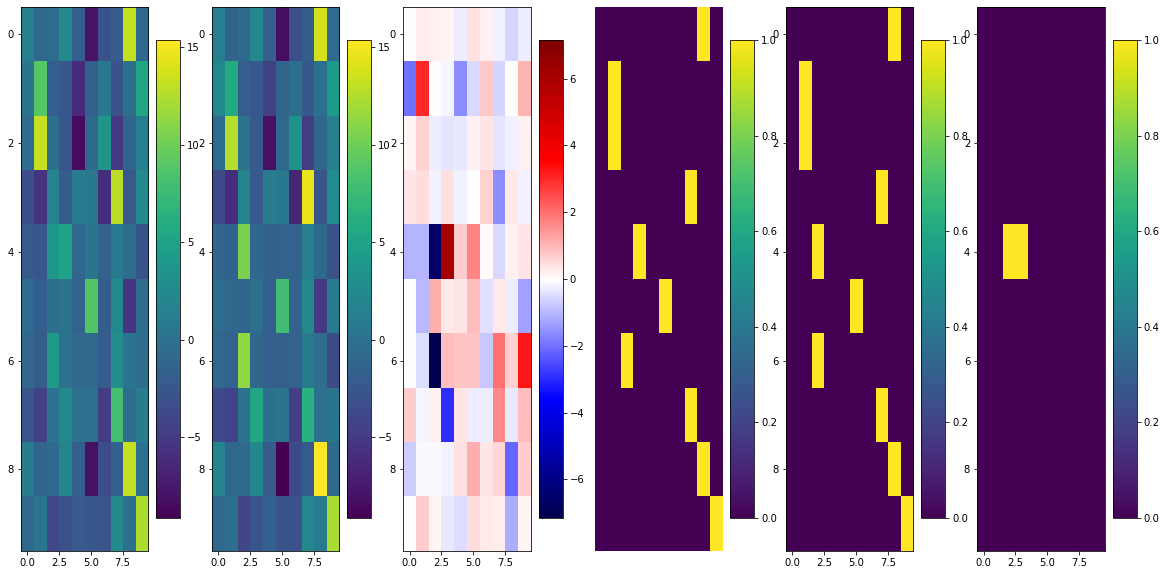

a-b in range [-3.7005252838134766 , 2.5049939155578613]


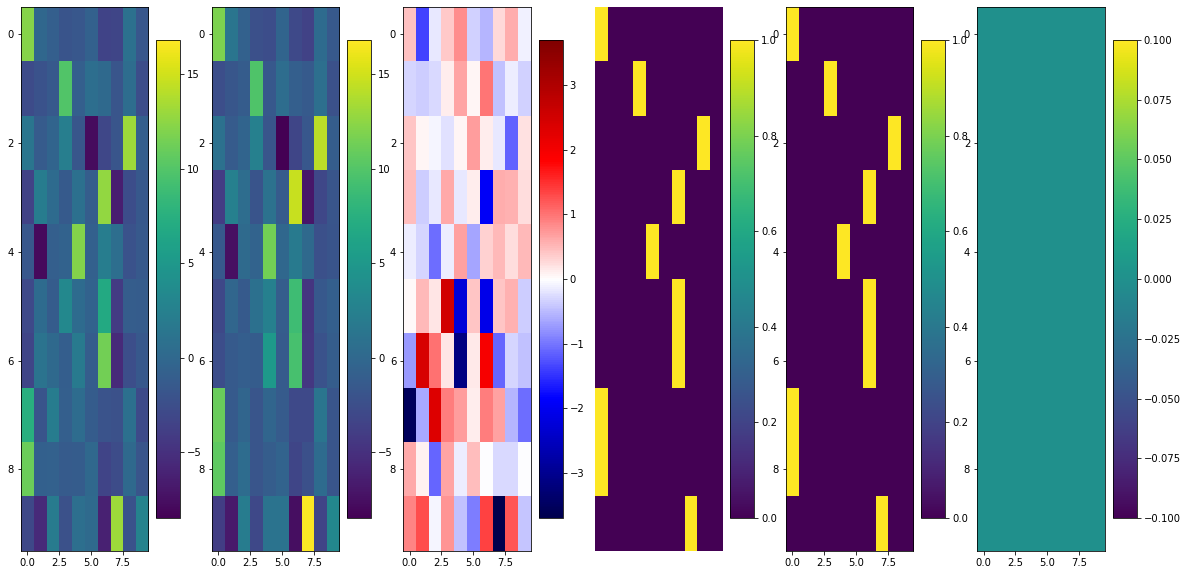

In [9]:
#check if g(.) and GP path match on test instances ====
FLAG_RELU = False
gpexmodule.renew_precomputed_XTX()
list_outputgpoutputg = gpexmodule.checkequal_f1path_gpath_ontest(10)
for n in range(len(list_outputgpoutputg)):
    a = list_outputgpoutputg[n][0]
    b = list_outputgpoutputg[n][1]
    if(FLAG_RELU == True):
        a = np_relu(a); b = np_relu(b)
    
    min_ab = min(np.min(a), np.min(b))
    max_ab = max(np.max(a), np.max(b))
    print("a-b in range [{} , {}]".format(np.min(a-b), np.max(a-b)))
    #print(np.round(a[0:5, 0:5], 2))
    #print(np.round(b[0:5, 0:5], 2))
    
    #compute the class activations ====
    gpexmodule.eval()
    with torch.no_grad():
        try:
            classactivation_a = gpexmodule.module_rawmodule.linear(torch.tensor(a).float().to(device))
            classactivation_b = gpexmodule.module_rawmodule.linear(torch.tensor(b).float().to(device))
            classactivation_a = classactivation_a.detach().cpu().numpy()
            classactivation_b = classactivation_b.detach().cpu().numpy()
            onehot_a = np.zeros((batchsize, 10))
            onehot_a[list(range(batchsize)), np.argmax(classactivation_a, 1).tolist()] = 1
            onehot_b = np.zeros((batchsize, 10))
            onehot_b[list(range(batchsize)), np.argmax(classactivation_b, 1).tolist()] = 1

            min_classactivations = min(np.min(classactivation_a), np.min(classactivation_b))
            max_classactivations = max(np.max(classactivation_a), np.max(classactivation_b))
        except:
            onehot_a = np.zeros((batchsize, 10))
            onehot_a[list(range(batchsize)), np.argmax(a, 1).tolist()] = 1
            onehot_b = np.zeros((batchsize, 10))
            onehot_b[list(range(batchsize)), np.argmax(b, 1).tolist()] = 1
    gpexmodule.train()
    
    plt.figure(figsize=(20,10))
    plt.subplot(1,6,1)
    plt.imshow(np.round(a, 2), vmin=min_ab, vmax=max_ab, aspect="auto"); plt.colorbar()
    plt.subplot(1,6,2)
    plt.imshow(np.round(b, 2), vmin=min_ab, vmax=max_ab, aspect="auto"); plt.colorbar()
    plt.subplot(1,6,3)
    plt.imshow(np.round(a-b, 2), cmap="seismic", vmin=-np.max(np.abs(a-b)),\
               vmax=np.max(np.abs(a-b)), aspect="auto"); plt.colorbar()
    plt.subplot(1,6,4)
    plt.imshow(onehot_a, vmin=0,
               vmax=1, aspect="auto")
    plt.axis("off")
    plt.colorbar()
    plt.subplot(1,6,5)
    plt.imshow(onehot_b, vmin=0,
               vmax=1, aspect="auto")
    plt.colorbar()
    plt.subplot(1,6,6)
    plt.imshow(np.abs(onehot_b - onehot_a), aspect="auto")
    plt.colorbar()
    plt.show()        

# Compute GP diff ANN

In [10]:
import gpex.evaluation
from gpex.evaluation import GPdiffANN_ontorchdl
from sklearn.metrics import cohen_kappa_score
from scipy import stats

output, dict_gt = GPdiffANN_ontorchdl(
    gpmodel = gpexmodule,
    dl_input = dl_test,
    input_device = device
)

np_gpann = np.array(
    [output[k] for k in output.keys()]
)
np_gt = np.array([dict_gt[k] for k in output.keys()])

numclasses = int(np_gpann.shape[1]/2)
list_correlation = []
for c in range(numclasses):
    list_correlation.append(
        stats.pearsonr(np_gpann[:, c], np_gpann[:, c+numclasses])[0]
    )
print("list correl = {}".format(list_correlation))
gp_labels = np.argmax(np_gpann[:, 0:numclasses], 1)
ann_labels = np.argmax(np_gpann[:, numclasses::], 1)
kappa_labels = cohen_kappa_score(gp_labels, ann_labels)
disaggreement = np.sum(gp_labels != ann_labels)
print("kappa between labels = {}".format(kappa_labels))
print("number of disagreements: {} out of {}".format(disaggreement, np_gpann.shape[0]))
acc_ann = np.sum(ann_labels == np_gt)/np_gpann.shape[0]
acc_gp = np.sum(gp_labels == np_gt)/np_gpann.shape[0]
print("Acuuray of ANN {}".format(acc_ann))
print("   Acuuracy of GP {}".format(acc_gp))

list correl = [0.9697233345732643, 0.9835862666796026, 0.9560573303821156, 0.9479392542254648, 0.9739619935949008, 0.9655683210823228, 0.9783267816627104, 0.978221308257538, 0.9761417859336705, 0.9834649387760845]
kappa between labels = 0.928445173508621
number of disagreements: 644 out of 10000
Acuuray of ANN 0.9543
   Acuuracy of GP 0.9226


# Depict the Correlation Scatter

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


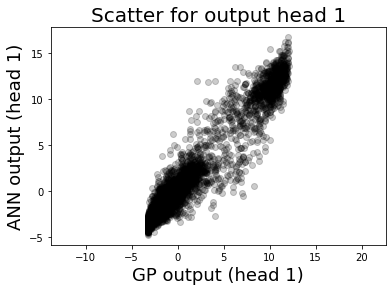

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


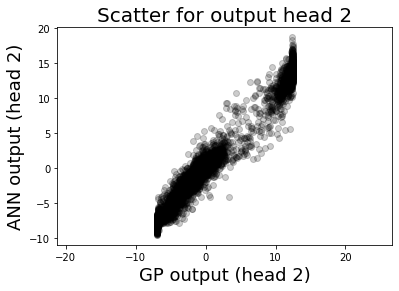

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


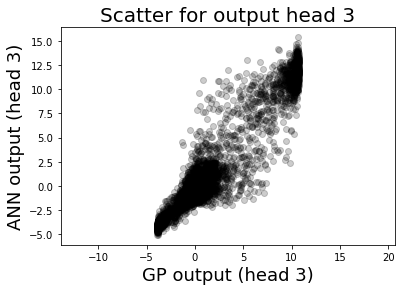

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


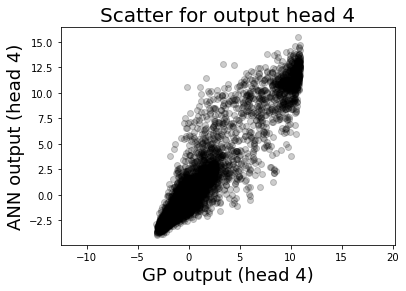

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


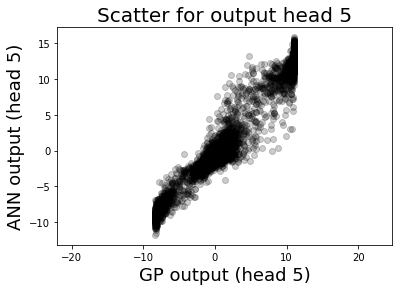

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


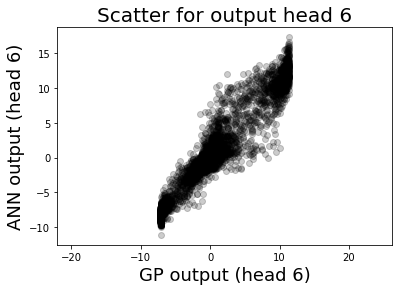

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


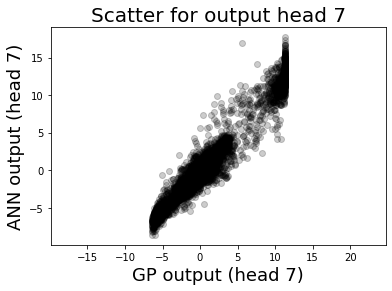

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


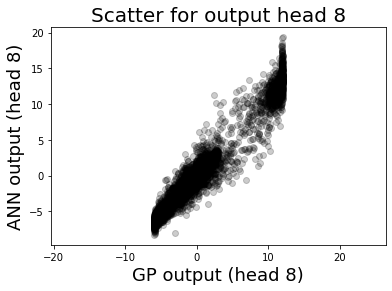

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


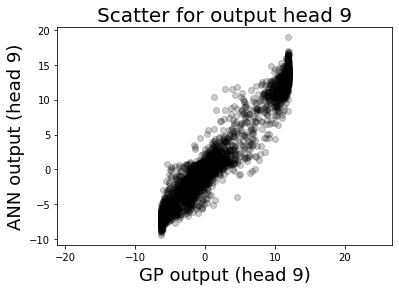

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


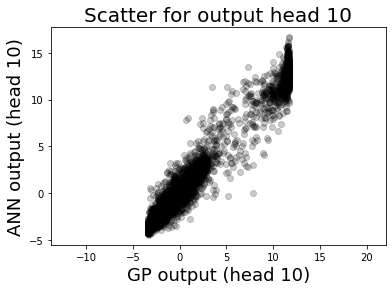

In [15]:
from scipy.special import softmax
np_gp = np_gpann[:,0:num_classes]
np_ann = np_gpann[:,num_classes::]
np_gp_softmax = softmax(np_gp, 1)
np_ann_softmax = softmax(np_ann, 1)

list_disaggrement = (np.argmax(np_gp, 1) != np.argmax(np_ann, 1)).tolist()
list_c = [0,0,0,0.2] #[[1,0,0,1] if(u==True) else [0,0,0,0.05] for u in list_disaggrement]
count_plotted = 0
for c in range(num_classes):
    plt.ioff()
    plt.figure()
    plt.scatter(np_gp[:,c], np_ann[:,c], c=np.array(list_c), marker='o', facecolors='none')
    plt.axis("equal")
    plt.xlabel("GP output (head {})".format(c+1), fontsize=18)
    plt.ylabel("ANN output (head {})".format(c+1), fontsize=18)
    plt.title("Scatter for output head {}".format(count_plotted+1), fontsize=20)
    count_plotted += 1
    
    plt.show()

# Inspect Nearest Neighbours

In [ ]:
def inspect_kernel(model_input, ds_input, input_device):
    model_input.eval()
    toret = []
    list_gty = []
    list_uncertainty = []
    list_similarities = []
    list_x, list_y = [], []
    list_output_g = []
    for n in range(len(ds_input)):
        print(" instance {} from {}".format(n, len(ds_input)), end='\r')
        x, y, _ = ds_input[n]
        output, uncertainty, output_similarities = \
                model_input.testingtime_forward(x.unsqueeze(0).to(input_device), y, n)
        #print("output_similaritites.shape = {}".format(output_similarities.shape))
        output = output[0]
        toret.append(output.detach().cpu().numpy())
        list_gty.append(y)
        list_uncertainty.append(uncertainty)
        list_similarities.append(output_similarities.detach().cpu().numpy())
        list_x.append(x); list_y.append(y)
        #feed the model to g(.) ====
        output_g, _, _ = \
                model_input.module_rawmodule(x.unsqueeze(0).to(input_device), y, n)
        list_output_g.append(output_g.detach().cpu().numpy().flatten().tolist())

    print("\n")
    toret = np.array(toret)
    toret = toret[:,0,:]
    output_g = np.array(list_output_g)
    print(output_g.shape)
    model_input.train()
    return toret, list_gty, list_uncertainty, list_similarities, list_x, list_y, output_g

In [ ]:
list_retval_inspectmodel = [inspect_kernel(gpmodel, ds_test, device)]

In [ ]:
ds_recurring.label_names = ds_recurring.dict_labelnames[b'label_names']

In [ ]:
# the two instances for the introduction of the paper ====
#%%capture
m = 10
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
import warnings
warnings.filterwarnings(action = "once")
plt.figure(figsize=((m+2)*10, 2*10))
count_subplot = 1
for n in [2619, 48]:
    print("n = {} ==========================".format(n))
#     fname_n, _ = ds_test._ntoimage(n)
#     fname_n = os.path.relpath(fname_n, ds_rootdir)
#     if(fname_n not in ds_split["fname_hoskys"]):
#         continue
    #fields common between all models
    _, list_gty, _, _, list_x, list_y, _ = list_retval_inspectmodel[0]
    x, y = list_x[n], list_y[n]
    
    
    warnings.filterwarnings("ignore")
    str_subfolder = ""
    idx_model = 0 #for idx_model in range(len(list_retval_inspectmodel)):
    list_predy, list_gty, list_uncertainty, list_similarities, _, _, output_g = \
                        list_retval_inspectmodel[idx_model]
    np_argmax_list_predyn = np.argmax(output_g[n])
    if(np_argmax_list_predyn == list_gty[n]):
        str_subfolder = str_subfolder + "True"
    else:
        str_subfolder = str_subfolder + "False"
    kn = list_similarities[n][np_argmax_list_predyn, :].flatten()
    idx_similars = np.argsort(-kn).tolist()[0:m]
    plt.ioff()
    plt.subplot(2, 1*(m+1), count_subplot); count_subplot+=1;
    plt.imshow(tfm_denormalize(x).cpu().numpy().transpose(1,2,0))
    print("{} =======> shown on {}".format(n, count_subplot-1))
    plt.axis('off')
    print("===== showed.")
    if(n == 2619):
        plt.title(
                r'$\boldsymbol{x}_{test}$',\
                fontsize=150
        )

    list_relevantinstances =[]
    for count_similars in range(len(idx_similars)):
        plt.subplot(2, 1*(m+1), count_subplot); count_subplot+=1;
        print("    n, m  = {}, {} shown on {}".format(n, count_similars, count_subplot-1))
        plt.imshow(
          tfm_denormalize(
                  ds_recurring[idx_similars[count_similars]][0]
              ).cpu().numpy().transpose(1,2,0),
        )
        plt.axis('off')
        if(n == 2619):
            plt.title(r"$\boldsymbol{x}_{i"+str(count_similars+1)+"}$", fontsize=150)
        list_relevantinstances.append(idx_similars[count_similars])
            
        
                
        
if(True):#os.path.isfile("InterpGP/{}/{}.png".format(str_subfolder, n)) == False):
    plt.savefig(
            "InterpGP/ToPublish/twohorses.jpg",
            dpi=50, bbox_inches='tight', pad_inches=0, Q=100
        )
    print("================= saved.")
plt.close()
#assert False
#enable_print()

In [ ]:
count_subplot

In [ ]:
%%capture
m = 10
import warnings
warnings.filterwarnings(action = "once")
for n in range(len(ds_test)):
    print("n = {} ==========================".format(n))
#     fname_n, _ = ds_test._ntoimage(n)
#     fname_n = os.path.relpath(fname_n, ds_rootdir)
#     if(fname_n not in ds_split["fname_hoskys"]):
#         continue
    #fields common between all models
    _, list_gty, _, _, list_x, list_y, _ = list_retval_inspectmodel[0]
    x, y = list_x[n], list_y[n]
    
    plt.figure(figsize=((m+2)*10, 1*10))
    warnings.filterwarnings("ignore")
    count_subplot = 1
    str_subfolder = ""
    idx_model = 0 #for idx_model in range(len(list_retval_inspectmodel)):
    list_predy, list_gty, list_uncertainty, list_similarities, _, _, output_g = \
                        list_retval_inspectmodel[idx_model]
    np_argmax_list_predyn = np.argmax(output_g[n])
    if(np_argmax_list_predyn == list_gty[n]):
        str_subfolder = str_subfolder + "True"
    else:
        str_subfolder = str_subfolder + "False"
    kn = list_similarities[n][np_argmax_list_predyn, :].flatten()
    idx_similars = np.argsort(-kn).tolist()[0:m]
    plt.ioff()
    plt.subplot(1, 1*(m+1), count_subplot); count_subplot+=1;
    plt.imshow(tfm_denormalize(x).cpu().numpy().transpose(1,2,0))
    plt.axis('off')
    print("===== showed.")
    plt.title("gt-label = {}\n predicted = {}\n instance {}".format(
                            ds_recurring.label_names[y],
                            ds_recurring.label_names[np_argmax_list_predyn],
                            n
                ), fontsize=100
             )

    list_relevantinstances =[]
    for count_similars in range(len(idx_similars)):
        plt.subplot(1, 1*(m+2), count_subplot); count_subplot+=1;
        plt.imshow(
          tfm_denormalize(
                  ds_recurring[idx_similars[count_similars]][0]
              ).cpu().numpy().transpose(1,2,0),
        )
        plt.axis('off')
        plt.title("instnace {}".format(idx_similars[count_similars]), fontsize=100)
        list_relevantinstances.append(idx_similars[count_similars])
            
        
                
        
    if(True):#os.path.isfile("InterpGP/{}/{}.png".format(str_subfolder, n)) == False):
        plt.savefig(
                "InterpGP/{}/{}/{}.jpg".format(str_subfolder, y, n),
                dpi=50, bbox_inches='tight', pad_inches=0, Q=80
            )
        print("================= saved.")
    plt.close()
    #assert False
#enable_print()

In [ ]:
ds_recurring.label_names

# ToPublish Nearet Neighbours

In [ ]:
def np_to_pilcompatible(x):
    x = x - np.min(x)
    x = x /np.max(x)
    toret = (x*255.0).astype('uint8')
    return toret 

In [ ]:
selected_airplane = [
    3, 1078, 1596, 1726, 269, 27,\
    10, 406, 1744, 2792,\
    179, 180, 499, 791, 928, 1241,\
    1365, 2079,\
    352, 258, 281, 886, 2548,\
    189, 289, 1203, 1440, 1579, 2375, 2468,\
    2877, 2964,\
    257, 276, 602
]
selected_automobile = [
    81, 114, 246,\
    9, 240, 645,\
    887, 865, 796, 1144
]
selected_bird = [
    303, 86, 623, 1196, 1392, 1481,\
    391, 592, 603, 697, 843, 1382,\
    498, 123, 430
]
selected_cat = [
    8, 432, 786, 950,\
    825, 1373, 1364
]
selected_deer = [
    40, 373, 1315,\
    188, 802, 872, 1484,\
    94, 328, 465, 1207
]
selected_dog = [
    502, 510, 549, 1329, 1337, 1438, 1598, 1694
]
selected_frog = [
    9903, 9902, 9615, 9546, 9527, 9456, 9450,\
    9425, 9342, 8940
]
selected_horse = [
    17, 99, 2619, 2470, 2297, 1615,\
    2626, 48, 2340,\
    203, 119, 2167, 1584,\
    57, 1602
]
selected_ship = [
    2, 108, 233, 242,\
    79, 80, 185,\
    368, 403, 694
]
selected_truck = [
    611, 940, 11, 14, 530, 585, 938, 213, 247, 538,\
    816, 38, 89, 259, 1104, 1707,\
    508, 517,\
    838, 922
]
selected_misclassified = [
    287, 4355, 1969, 7892, 1858, 158, 1506, 1580, 3446, 8898, 6419
]
selected_all = selected_airplane +\
            selected_automobile + selected_bird +\
            selected_cat + selected_deer + selected_dog +\
            selected_frog + selected_horse + selected_ship+\
            selected_truck + selected_misclassified

In [ ]:
print(len(selected_all))
print(len(list(set(selected_all))))
for u in selected_all:
    if(selected_all.count(u) > 1):
        print(u)

In [ ]:
selected_n = selected_all
#%%capture
m = 10
import warnings
warnings.filterwarnings(action = "once")
for n in range(len(ds_test)):
    if(n not in selected_n):
        continue
    
    path_tosave = "InterpGP/ToPublish/Cifar10_NearesetNeighbours/"
    if(os.path.isdir(os.path.join(path_tosave, "{}/".format(n)))):
        assert False
    else:
        os.mkdir(os.path.join(path_tosave, "{}/".format(n)))
    path_instance_n = os.path.join(path_tosave, "{}/".format(n))
    
    print("n = {} ==========================".format(n))
#     fname_n, _ = ds_test._ntoimage(n)
#     fname_n = os.path.relpath(fname_n, ds_rootdir)
#     if(fname_n not in ds_split["fname_hoskys"]):
#         continue
    #fields common between all models
    _, list_gty, _, _, list_x, list_y, _ = list_retval_inspectmodel[0]
    x, y = list_x[n], list_y[n]
    
    #plt.figure(figsize=((m+2)*10, 1*10))
    warnings.filterwarnings("ignore")
    count_subplot = 1
    str_subfolder = ""
    idx_model = 0 #for idx_model in range(len(list_retval_inspectmodel)):
    list_predy, list_gty, list_uncertainty, list_similarities, _, _, output_g = \
                        list_retval_inspectmodel[idx_model]
    np_argmax_list_predyn = np.argmax(output_g[n])
    if(np_argmax_list_predyn == list_gty[n]):
        str_subfolder = str_subfolder + "True"
    else:
        str_subfolder = str_subfolder + "False"
    kn = list_similarities[n][np_argmax_list_predyn, :].flatten()
    idx_similars = np.argsort(-kn).tolist()[0:m]
    #plt.ioff()
    #plt.subplot(1, 1*(m+1), count_subplot); count_subplot+=1;
    #plt.imshow(tfm_denormalize(x).cpu().numpy().transpose(1,2,0))
    pil_tosave = Image.fromarray(
                    np_to_pilcompatible(
                        tfm_denormalize(x).cpu().numpy().transpose(1,2,0)
                    )
    )
    pil_tosave.save(
        os.path.join(
            path_instance_n, "instance.png"
        )
    )
    
    #plt.axis('off')
    print("===== showed.")
    

    list_relevantinstances =[]
    for count_similars in range(len(idx_similars)):
#         plt.subplot(1, 1*(m+2), count_subplot); count_subplot+=1;
#         plt.imshow(
#           tfm_denormalize(
#                   ds_recurring[idx_similars[count_similars]][0]
#               ).cpu().numpy().transpose(1,2,0),
#         )
        pil_tosave = Image.fromarray(
                    np_to_pilcompatible(
                        tfm_denormalize(
                              ds_recurring[idx_similars[count_similars]][0]
                          ).cpu().numpy().transpose(1,2,0),
                    )
        )
        pil_tosave.save(
            os.path.join(
                path_instance_n, "{}.png".format(count_similars+1)
            )
        )
#         plt.axis('off')
#         plt.title("instnace {}".format(idx_similars[count_similars]), fontsize=100)
        list_relevantinstances.append(idx_similars[count_similars])
            
        
                
        
#     if(True):#os.path.isfile("InterpGP/{}/{}.png".format(str_subfolder, n)) == False):
#         plt.savefig(
#                 "InterpGP/{}/{}/{}.jpg".format(str_subfolder, y, n),
#                 dpi=50, bbox_inches='tight', pad_inches=0, Q=80
#             )
#         print("================= saved.")
#     plt.close()
#     #assert False
# #enable_print()

# Explain Similarities CAM-like

In [ ]:
import torchofgp
import torchofgp.kernel_explainers
from torchofgp.kernel_explainers import *

In [ ]:
list_retval_inspectmodel = [inspect_kernel(gpmodel, ds_test, device)]

In [ ]:
%%capture
#explain the similarity itself =====
m = 10
import warnings
warnings.filterwarnings(action = "once")
for n in range(len(ds_test)):
    
    #fields common between all models
    _, list_gty, _, _, list_x, list_y, _ = list_retval_inspectmodel[0]
    x, y = list_x[n], list_y[n]
    
    plt.figure(figsize=((m+1)*10, 3*10))
    warnings.filterwarnings("ignore")
    count_subplot = 1
    str_subfolder = ""
    for idx_model in range(len(list_retval_inspectmodel)):
        list_predy, list_gty, list_uncertainty, list_similarities, _, _, output_g = \
                            list_retval_inspectmodel[idx_model]
        np_argmax_list_predyn = np.argmax(output_g[n])
        if(np_argmax_list_predyn == list_gty[n]):
            str_subfolder = str_subfolder + "True"
        else:
            str_subfolder = str_subfolder + "False"
        kn = list_similarities[n][np_argmax_list_predyn, :].flatten()
        idx_similars = np.argsort(-kn).tolist()[0:m]
        plt.ioff()
        plt.subplot(3, 1*(m+1), count_subplot); count_subplot+=1;
        plt.imshow(tfm_denormalize(x).cpu().numpy().transpose(1,2,0))
        plt.title("gt-label = {}\n predicted = {}\n instance {}".format(
                                ds_recurring.label_names[y],
                                ds_recurring.label_names[np_argmax_list_predyn],
                                n
                    ), fontsize=100
                 )
        plt.axis('off')
        
        list_relevantinstances =[]
        for count_similars in range(len(idx_similars)):
            plt.subplot(3, 1*(m+1), count_subplot); count_subplot+=1;
            plt.imshow(
              tfm_denormalize(ds_recurring[idx_similars[count_similars]][0]).cpu().numpy().transpose(1,2,0),
            )
            plt.axis('off')
            plt.title("instnace {}".format(idx_similars[count_similars]), fontsize=100)
            list_relevantinstances.append(idx_similars[count_similars])
            
        
        
        
        #plot rows 2 (explanations for x2)
        plt.subplot(3, 1*(m+1), count_subplot); count_subplot+=1;
        plt.imshow(tfm_denormalize(x).cpu().numpy().transpose(1,2,0))
        plt.axis('off')
        for count_similars in range(len(idx_similars)):
            x2 = ds_recurring[idx_similars[count_similars]][0].unsqueeze(0).to(device)
            x1 = x.unsqueeze(0).to(device)
            explanationx1x2 = explainkern_imgimg_CAMlike(
              gpmodel = gpmodel,
              func_forward_beforeavgpool = gpmodel.module_f1.module.forward_untilbeforeavgpooling,
              x1 = x.to(device),
              x2 = ds_recurring[idx_similars[count_similars]][0].to(device),
              idx_ann_outputhead = y,
              du_per_gp = du_per_class,
              scale_resizemaps = 1.0
            )
            
            toret1 = np.sum(np.sum(explanationx1x2, axis=-1), axis=-1)
            toret2 = np.sum(np.sum(explanationx1x2, axis=0), axis=0)
            plt.subplot(3, 1*(m+1), count_subplot); count_subplot+=1;
            plt.imshow(toret2, cmap="seismic", vmin=np.min(toret2), vmax=np.max(toret2))
            plt.axis('off')
        #plt.subplot(3, 1*(m+1), count_subplot); count_subplot+=1;
        #plt.hist(kn.flatten(), bins=200)
        
        #plot rows 3 (explanations for the instance itself)
        plt.subplot(3, 1*(m+1), count_subplot); count_subplot+=1;
        plt.imshow(tfm_denormalize(x).cpu().numpy().transpose(1,2,0))
        plt.axis('off')
        for count_similars in range(len(idx_similars)):
            x2 = ds_recurring[idx_similars[count_similars]][0].unsqueeze(0).to(device)
            x1 = x.unsqueeze(0).to(device)
            explanationx1x2 = explainkern_imgimg_CAMlike(
              gpmodel = gpmodel,
              func_forward_beforeavgpool = gpmodel.module_f1.module.forward_untilbeforeavgpooling,
              x1 = x.to(device),
              x2 = ds_recurring[idx_similars[count_similars]][0].to(device),
              idx_ann_outputhead = y,
              du_per_gp = du_per_class,
              scale_resizemaps = 1.0
            )
            
            toret1 = np.sum(np.sum(explanationx1x2, axis=-1), axis=-1)
            toret2 = np.sum(np.sum(explanationx1x2, axis=0), axis=0)
            plt.subplot(3, 1*(m+1), count_subplot); count_subplot+=1;
            plt.imshow(toret1, cmap="seismic", vmin=np.min(toret1), vmax=np.max(toret1))
                
        
    if(os.path.isfile("InterpGP/Kernel/{}/{}.jpg".format(str_subfolder, n)) == False):
        plt.savefig(
                "InterpGP/Kernel/{}/{}.jpg".format(str_subfolder, n),
                dpi=20, bbox_inches='tight', pad_inches=0, Q=80
            )
    plt.close()
    #assert False
#enable_print()

# Explain by Regions

In [ ]:
import torchofgp
import torchofgp.kernel_explainers
from torchofgp.kernel_explainers import *

In [ ]:
list_retval_inspectmodel = [inspect_kernel(gpmodel, ds_test, device)]

In [ ]:
# file_retvals = open('InterpGP/retvals.pkl', 'wb')
# pickle.dump(list_retval_inspectmodelval_inspectmodel, file_retvals, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
file_retvals = open('InterpGP/retvals.pkl', 'rb')
list_retval_inspectmodel = pickle.load(file_retvals)

In [ ]:
#settings ===
n1 = 21
n2 = 9064
rgbsigma = 0.0
#explain the similarity ===
_, list_gty, _, _, list_x, list_y, _ = list_retval_inspectmodel[0]
x1, y1 = list_x[n1], list_y[n1]
x2 = ds_recurring[n2][0]
explanationx1x2 = explainkern_imgimg_CAMlike(
      gpmodel = gpmodel,
      func_forward_beforeavgpool = gpmodel.module_f1.module.forward_untilbeforeavgpooling,
      x1 = x1.to(device),
      x2 = x2.to(device),
      idx_ann_outputhead = y1,
      du_per_gp = du_per_class,
      scale_resizemaps = 1.0,
      mode_upsample='nearest',
      flag_aligcorners = None
)
explanationx1x2 = explanationx1x2 * ((explanationx1x2>0.0) + 0.0)
print("shape of CAM-like output = {}".format(explanationx1x2.shape))

#explanationx1x2 = explanationx1x2/np.max(explanationx1x2) #TODO:check
#explanationx1x2[explanationx1x2 < 0.1] = 0.0 #TODO:check

#compute the heatmaps for img1 and img2 ===
heatmap_1 = np.sum(np.sum(explanationx1x2, 3), 2)
heatmap_2 = np.sum(np.sum(explanationx1x2, 0), 0)
normalized_heatmap_1 = heatmap_1/np.max(heatmap_1)
normalized_heatmap_2 = heatmap_2/np.max(heatmap_2)

#assert False
#make the pixel similarity matrix ====
num_pix1 = explanationx1x2.shape[0] * explanationx1x2.shape[1]
num_pix2 = explanationx1x2.shape[2] * explanationx1x2.shape[3]
np_pixelmatrix = np.zeros((num_pix1+num_pix2 , num_pix1+num_pix2))

#for pixels of image 1
for idx_ij in range(num_pix1):
    i, j = np.unravel_index(idx_ij, [explanationx1x2.shape[0], explanationx1x2.shape[1]])
    #fill the similarities between i,j and image 2
    for idx_kl in range(num_pix2):
        k, l = np.unravel_index(idx_kl, [explanationx1x2.shape[2], explanationx1x2.shape[3]])
        np_pixelmatrix[idx_ij, idx_kl] = explanationx1x2[i,j,k,l]
    #fill the similarities between i,j and image 1 
    for idx_i2j2 in range(num_pix1):
        if(idx_i2j2 != idx_ij):
            i2, j2 = np.unravel_index(
                    idx_i2j2, [explanationx1x2.shape[0], explanationx1x2.shape[1]]
                )
            dist = np.array([i,j]) - np.array([i2,j2])
            if(rgbsigma != 0.0):
                rbf = np.exp(np.sum(-dist*dist) / (2.0*rgbsigma * rgbsigma))
            else:
                rbf = 0.0
            np_pixelmatrix[idx_ij, idx_i2j2] = rbf
            
#for pixels of image 2
for idx_kl in range(num_pix2):
    k, l = np.unravel_index(idx_kl, [explanationx1x2.shape[2], explanationx1x2.shape[3]])
    #fill the similarities between k,l and image 1
    for idx_ij in range(num_pix1):
        i, j = np.unravel_index(idx_ij, [explanationx1x2.shape[0], explanationx1x2.shape[1]])
        np_pixelmatrix[idx_kl, idx_ij] = explanationx1x2[i,j,k,l]
    #fill the similarities between k,l and image 2 
    for idx_k2l2 in range(num_pix2):
        if(idx_k2l2 != idx_kl):
            k2, l2 = np.unravel_index(
                    idx_k2l2, [explanationx1x2.shape[2], explanationx1x2.shape[3]]
                )
            dist = np.array([k,l]) - np.array([k2,l2])
            if(rbf != 0.0):
                rbf = np.exp(np.sum(-dist*dist) / (2.0*rgbsigma * rgbsigma))
            else:
                rbf = 0.0
            np_pixelmatrix[idx_kl, idx_k2l2] = rbf
            
print("Computed the similarity matrix of shape {}".format(np_pixelmatrix.shape))



In [ ]:
#plot the histogram of two heatmaps ===
plt.figure()
plt.hist(heatmap_1.flatten(), bins=50)
plt.show()
plt.figure()
plt.hist(heatmap_2.flatten())
plt.show()

In [ ]:

#run spectral clustering on pixel similarity matrix ====
#settings ===
n_clusters = 2

from sklearn.cluster import SpectralClustering
clustering = SpectralClustering(
         affinity = "precomputed",
         n_clusters= n_clusters,
         random_state=1
).fit(np_pixelmatrix+0.0)

#show the clustering result
plt.figure(figsize=((clustering.n_clusters+2)*10, 2*10))
count_subplot = 1
plt.subplot(2, clustering.n_clusters+2, count_subplot); count_subplot +=clustering.n_clusters+2;
plt.imshow(tfm_denormalize(x1).cpu().numpy().transpose(1,2,0))
plt.axis("off")

plt.subplot(2, clustering.n_clusters+2, count_subplot); count_subplot -= (clustering.n_clusters+1);
plt.imshow(tfm_denormalize(x2).cpu().numpy().transpose(1,2,0))
plt.axis("off")


plt.subplot(2, clustering.n_clusters+2, count_subplot); count_subplot +=clustering.n_clusters+2;
plt.imshow(heatmap_1, cmap='seismic')
plt.axis("off")

plt.subplot(2, clustering.n_clusters+2, count_subplot); count_subplot -= (clustering.n_clusters+1);
plt.imshow(heatmap_2, cmap='seismic')
plt.axis("off")


for c in range(clustering.n_clusters):
    idx_pixelsinc = np.where(np.array(clustering.labels_) == c)[0].tolist() #in rng pix1+pix2
    
    
    #plot the cluster c for image 1
    img1_inc = np.zeros((explanationx1x2.shape[0], explanationx1x2.shape[1]))
    plt.subplot(
        2, clustering.n_clusters+2,
        count_subplot); count_subplot +=clustering.n_clusters+2;
    idx_img1_inc = [idx for idx in idx_pixelsinc if(idx<num_pix1)]
    if(idx_img1_inc != []):
        np_img1_ij = np.array(np.unravel_index(idx_img1_inc, img1_inc.shape))
        img1_inc[np_img1_ij[0,:] , np_img1_ij[1,:]] = 1
    plt.imshow(img1_inc, vmin=0, vmax=1)
    plt.axis('off')
    
    #plot the cluster c for image 2
    img2_inc = np.zeros((explanationx1x2.shape[2], explanationx1x2.shape[3]))
    plt.subplot(
        2, clustering.n_clusters+2,
        count_subplot); count_subplot -= (clustering.n_clusters+1);
    idx_img2_inc = [idx-num_pix1 for idx in idx_pixelsinc if(idx>=num_pix1)]
    if(idx_img2_inc != []):
        np_img2_ij = np.array(np.unravel_index(idx_img2_inc, img2_inc.shape))
        img2_inc[np_img2_ij[0,:] , np_img2_ij[1,:]] = 1
    plt.imshow(img2_inc, vmin=0, vmax=1)
    plt.axis('off')
plt.show()


In [ ]:
#explain the similarity itself =====
m = 5
import warnings
warnings.filterwarnings(action = "once")
for n in range(len(ds_test)):
    fname_n, _ = ds_test._ntoimage(n)
    fname_n = os.path.relpath(fname_n, ds_rootdir)
#     if(fname_n not in ds_split["fname_hoskys"]):
#         continue
    #fields common between all models
    _, list_gty, _, _, list_x, list_y, _ = list_retval_inspectmodel[0]
    x, y = list_x[n], list_y[n]
    
    plt.figure(figsize=((m+1)*10, 3*10))
    warnings.filterwarnings("ignore")
    count_subplot = 1
    str_subfolder = ""
    for idx_model in range(len(list_retval_inspectmodel)):
        list_predy, list_gty, list_uncertainty, list_similarities, _, _, output_g = \
                            list_retval_inspectmodel[idx_model]
        np_argmax_list_predyn = np.argmax(output_g[n])
        if(np_argmax_list_predyn == list_gty[n]):
            str_subfolder = str_subfolder + "True"
        else:
            str_subfolder = str_subfolder + "False"
        kn = list_similarities[n][np_argmax_list_predyn, :].flatten()
        idx_similars = np.argsort(-kn).tolist()[0:m]
        plt.ioff()
        plt.subplot(3, 1*(m+1), count_subplot); count_subplot+=1;
        plt.imshow(tfm_denormalize(x).cpu().numpy().transpose(1,2,0))
        plt.title("gt-label = {}\n predicted = {}\n instance {}".format(
                                ["dog", "wolf"][y],
                                ["dog", "wolf"][np_argmax_list_predyn],
                                n
                    ), fontsize=100
                 )
        
        list_relevantinstances =[]
        for count_similars in range(len(idx_similars)):
            plt.subplot(3, 1*(m+1), count_subplot); count_subplot+=1;
            plt.imshow(
              tfm_denormalize(ds_recurring[idx_similars[count_similars]][0]).cpu().numpy().transpose(1,2,0),
            )
            plt.title("instnace {}".format(idx_similars[count_similars]), fontsize=100)
            list_relevantinstances.append(idx_similars[count_similars])
            
        
        
        
        #plot rows 2 (explanations for x2)
        plt.subplot(3, 1*(m+1), count_subplot); count_subplot+=1;
        plt.imshow(tfm_denormalize(x).cpu().numpy().transpose(1,2,0))
        for count_similars in range(len(idx_similars)):
            x2 = ds_recurring[idx_similars[count_similars]][0].unsqueeze(0).to(device)
            x1 = x.unsqueeze(0).to(device)
            explanationx1x2 = explainkern_imgimg_CAMlike(
              gpmodel = gpmodel,
              func_forward_beforeavgpool = gpmodel.module_f1.module.forward_untilbeforeavgpooling,
              x1 = x.to(device),
              x2 = ds_recurring[idx_similars[count_similars]][0].to(device),
              idx_ann_outputhead = y,
              du_per_gp = du_per_class,
              scale_resizemaps = 2.0
            )
            
            
            
            
            toret1 = np.sum(np.sum(explanationx1x2, axis=-1), axis=-1)
            toret2 = np.sum(np.sum(explanationx1x2, axis=0), axis=0)
            plt.subplot(3, 1*(m+1), count_subplot); count_subplot+=1;
            plt.imshow(toret2, cmap="seismic", vmin=np.min(toret2), vmax=np.max(toret2))
        #plt.subplot(3, 1*(m+1), count_subplot); count_subplot+=1;
        #plt.hist(kn.flatten(), bins=200)
        
        #plot rows 3 (explanations for the instance itself)
        plt.subplot(3, 1*(m+1), count_subplot); count_subplot+=1;
        plt.imshow(tfm_denormalize(x).cpu().numpy().transpose(1,2,0))
        for count_similars in range(len(idx_similars)):
            x2 = ds_recurring[idx_similars[count_similars]][0].unsqueeze(0).to(device)
            x1 = x.unsqueeze(0).to(device)
            explanationx1x2 = explainkern_imgimg_CAMlike(
              gpmodel = gpmodel,
              func_forward_beforeavgpool = gpmodel.module_f1.module.forward_untilbeforeavgpooling,
              x1 = x.to(device),
              x2 = ds_recurring[idx_similars[count_similars]][0].to(device),
              idx_ann_outputhead = y,
              du_per_gp = du_per_class,
              scale_resizemaps = 2.0
            )
            
            toret1 = np.sum(np.sum(explanationx1x2, axis=-1), axis=-1)
            toret2 = np.sum(np.sum(explanationx1x2, axis=0), axis=0)
            plt.subplot(3, 1*(m+1), count_subplot); count_subplot+=1;
            plt.imshow(toret1, cmap="seismic", vmin=np.min(toret1), vmax=np.max(toret1))
                
        
    if(os.path.isfile("InterpGP/RegionBased/{}/{}.png".format(str_subfolder, n)) == False):
        plt.savefig(
                "InterpGP/RegionBased/{}/{}.png".format(str_subfolder, n),
                dpi=80, bbox_inches='tight', pad_inches=0, Q=100
            )
    plt.close()
    assert False
#enable_print()


# Depict the Prototypes

In [ ]:
list_label_recurring = [ds_recurring.list_labelnames.index(ds_recurring._ntoimage(n)[1]+"/") for n in range(len(ds_recurring))]
def inspect_kernel(module_input, dl_input, list_label_recurring):
    np_lable_recurring = np.array(list_label_recurring)
    dict_class_to_sumranks = {u:0.0 for u in range(module_input.Dv)}
    with torch.no_grad():
        for idx, data in enumerate(dl_input):
            if((idx%10) == 0):
                print("Finished {} out of {}".format(
                    idx, len(dl_input.dataset)/dl_input.batch_size
                ), end='\r')
            x, y, n = data
            output, uncertainty, output_similarities = \
                module_input.testingtime_forward(x.to(device), y, n)
            output_similarities = output_similarities.detach().cpu().numpy() #[9xbatchsizex M]
            for idx_inminibatch, idx_inds in enumerate(n):
                xn_similarities = output_similarities[int(y[idx_inminibatch]),idx_inminibatch, :] #[M]
                xn_similarities = xn_similarities.flatten()
                xn_similarities = xn_similarities[np_lable_recurring == int(y[idx_inminibatch])]
                dict_class_to_sumranks[int(y[idx_inminibatch])] += np.argsort(-xn_similarities)
                
    
    return dict_class_to_sumranks

In [ ]:
dict_class_to_sumranks = inspect_kernel(gpmodel, dl_test, list_label_recurring)

In [ ]:
# pickle.dump( dict_class_to_sumranks, open("TrainingHistory/dict_class_to_sumranks.pkl", "wb"))

In [ ]:
# dict_class_to_sumranks = pickle.load( open( "TrainingHistory/dict_class_to_sumranks.pkl", "rb" ) )

In [ ]:
for k in dict_class_to_sumranks.keys():
    plt.figure()
    plt.hist(dict_class_to_sumranks[k]/len(dict_class_to_sumranks[k].tolist()), bins=200)
    plt.title("histogram of avg. ranks among the training instances \n for class {}.".format(k))
    plt.show()

In [ ]:
%matplotlib inline
import relatedwork
import relatedwork.utils.transforms
tfm_denormalize = relatedwork.utils.transforms.ImgnetDenormalize()
#open the app to check whether the sample-compression scheme matches human's ====
num_tocompare = 10
input_class = int(input("Please input the class (between 0 and 9)."))
plt.figure()
plt.hist(dict_class_to_sumranks[input_class]/\
         len(dict_class_to_sumranks[input_class].tolist()), bins=200)
plt.show()
input_threshold = float(input("Please enter a threshold based on the histogram."))
#divide instances based on their ranks
np_label_recurring = np.array(list_label_recurring)
idx_k_inds = np.array(range(len(ds_recurring)))[np_label_recurring == input_class]

idx_highrank_inlocal =  np.where(dict_class_to_sumranks[input_class] <\
                          (input_threshold*len(dict_class_to_sumranks[input_class].tolist())))[0]
idx_highrank_inlocal = idx_highrank_inlocal.tolist()
idx_highrank_inds = idx_k_inds[dict_class_to_sumranks[input_class] <\
                               input_threshold*len(dict_class_to_sumranks[input_class].tolist())]
idx_lowrank_inds = np.array(list(set(range(len(ds_recurring))).difference(idx_highrank_inds)))
assert(len(idx_highrank_inds.tolist())+len(idx_lowrank_inds.tolist()) == len(ds_recurring))
print("{} percent of instances are below the threshold. exact num = {}"\
      .format(100*len(idx_highrank_inds)/(np.sum(np_label_recurring==input_class)+0.0),\
              len(idx_highrank_inds.tolist())))
score = 0
for n in range(num_tocompare):
    n_high = random.choice(idx_highrank_inds)
    n_low = random.choice(idx_lowrank_inds)
    img_high = ds_recurring[n_high][0]
    img_low  = ds_recurring[n_low][0]
    
    list_toshow = [img_high, img_low]
    flag_fillped = False
    if(np.random.rand()<0.5):
        list_toshow = [img_low, img_high]
        flag_fillped = True
    
    
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(tfm_denormalize(list_toshow[0]).cpu().numpy().transpose(1,2,0))
    plt.subplot(1,2,2)
    plt.imshow(tfm_denormalize(list_toshow[1]).cpu().numpy().transpose(1,2,0))
    plt.show()
    input_selection = int(input("Which image (left or right) seems a prototype?"))
    assert(input_selection in [0,1])
    if(input_selection == 0):
        if(flag_fillped == True):
            score += 1
    if(input_selection == 1):
        if(flag_fillped == False):
            score += 1
print("score = {}".format(score/(num_tocompare+0.0)))

# np.max(dict_class_to_sumranks[input_class])

In [ ]:
np.min(dict_class_to_sumranks[input_class]/\
         len(dict_class_to_sumranks[input_class].tolist()))

In [ ]:
def get_x_onkernelspace(gpmodel, dl_input):
    gpmodel.eval()
    dict_n_to_kernelspace = {}
    with torch.no_grad():
        for idx, data in enumerate(dl_input):
            if((idx%10) == 0):
                print("Finished {} out of {}".format(
                    idx, len(dl_input.dataset)/dl_input.batch_size
                ), end='\r')
            x, _, n = data
            output_f1 = gpmodel.module_f1(x.to(device))
            output_f1 = output_f1[:,:,0,0].detach().cpu().numpy()
            
            for idx_inminibatch, idx_inds in enumerate(n):
                dict_n_to_kernelspace[idx_inds] = output_f1[idx_inminibatch,:].flatten().tolist()
    
    X_on_kernelspace = []
    gpmodel.train()
    return X_on_kernelspace

In [ ]:
inspect_kernel(gpmodel, dl_recurring)

In [ ]:
a = np.zeros((40000, 40000))

In [ ]:
import numpy as np
a = [
1,
2,
5,
6,
7,
8,
9,
11,
14
]
a = np.array(a)
b = [u+1 for u in range(len(a.tolist()))]
b.reverse()
print(np.sum(a*b))

In [ ]:
l = [1,2,3]
l.reverse()
print(l)

In [ ]:
b